## 1. Tải bộ dữ liệu

In [ ]:
import polars as pl
from tqdm import tqdm
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

In [ ]:
import requests

url = "https://lfs.aminer.cn/misc/moocdata/data/mooccube2/entities/reply.json"
reply_df = pl.read_ndjson(url)
reply_df.head()

id,user_id,text,create_time
str,str,str,str
"""Rp_1""","""U_10030806""","""测试回复""","""2019-08-05 12:55:54"""
"""Rp_2""","""U_10031397""","""赞""","""2019-08-09 16:39:06"""
"""Rp_3""","""U_10031531""","""好喜欢""","""2019-08-10 22:39:35"""
"""Rp_4""","""U_10031508""","""你也好棒""","""2019-08-12 14:43:34"""
"""Rp_5""","""U_10031508""","""嗯对""","""2019-08-12 14:44:51"""


## 2. Khám phá dữ liệu

### 2.1 Thống kê mô tả

#### 2.1.1 Sử dụng hàm `shape` để xem kích thước của một DataFrame (số hàng, số cột)

In [ ]:
reply_df.shape

(331011, 4)

#### 2.1.2 Sử dụng hàm `info()` để cung cấp một bản tóm tắt ngắn gọn của DataFrame (tên cột, kiểu dữ liệu, số lượng giá trị không bị thiếu)

In [ ]:
reply_df = reply_df.to_pandas()
reply_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331011 entries, 0 to 331010
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           331011 non-null  object
 1   user_id      331011 non-null  object
 2   text         331011 non-null  object
 3   create_time  331011 non-null  object
dtypes: object(4)
memory usage: 10.1+ MB


#### 2.1.3 Khảo sát về các cột trong bộ dữ liệu

In [ ]:
reply_df.columns

Index(['id', 'user_id', 'text', 'create_time'], dtype='object')

In [ ]:
num_rows = reply_df.count()
num_columns = len(reply_df.columns)
print(f"Số hàng: {num_rows}, Số cột: {num_columns}")

Số hàng: id             331011
user_id        331011
text           331011
create_time    331011
dtype: int64, Số cột: 4


In [ ]:
reply_df.describe()

,id,user_id,text,create_time
count,331011,331011,331011,331011
unique,331011,50313,148937,323978
top,Rp_1,U_12137387,回答正确，有自己的见解，继续努力。,2020-10-23 15:00:59
freq,1,22477,15965,14


In [ ]:
reply_df['id'].value_counts()

,count
id,
Rp_1,1
Rp_221061,1
Rp_221039,1
Rp_221038,1
Rp_221037,1
...,...
Rp_110629,1
Rp_110628,1
Rp_110627,1


In [ ]:
reply_df['user_id'].value_counts()

,count
user_id,
U_12137387,22477
U_3558829,11773
U_15053528,10013
U_10842547,8291
U_9741717,5796
...,...
U_21383248,1
U_12254072,1
U_12136945,1


In [ ]:
reply_df['text'].value_counts()

,count
text,
回答正确，有自己的见解，继续努力。,15965
回答正确，但不够全面。,5745
不错,3420
打卡,3353
是的,2495
...,...
视频可以看吗？,1
最近豪华游轮的新闻也很多，值得我们深思,1
海员日的时候，海巡船会开放参观哦,1


Thống kê số lượng reply của học viên

In [ ]:
user_text_counts = reply_df.groupby('user_id')['text'].count().reset_index()

user_text_counts.columns = ['user_id', 'text_count']

user_text_counts = user_text_counts.sort_values(by='text_count', ascending=False)

print(user_text_counts.head(20)) # View the top users with the most replies

          user_id  text_count
5559   U_12137387       22477
43455   U_3558829       11773
13679  U_15053528       10013
1349   U_10842547        8291
50088   U_9741717        5796
327    U_10238951        4811
1350   U_10842580        3804
48907   U_8264065        3773
13844  U_15092855        3293
13841  U_15092062        3249
21397  U_19703047        3210
44261    U_386702        3094
1348   U_10842542        3033
49110   U_8522515        2891
13845  U_15092878        2478
10628  U_13568204        2398
438    U_10339825        2360
47208   U_6484049        2324
10630  U_13568219        2213
935    U_10618081        2204


Thống kê số lượng reply theo năm

In [ ]:
# Convert the 'create_time' column to datetime format
reply_df['create_time'] = pd.to_datetime(reply_df['create_time'], errors='coerce')

# Extract the year from the 'create_time' column
reply_df['year'] = reply_df['create_time'].dt.year

# Group the data by year and count the number of replies for each year
yearly_reply_counts = reply_df.groupby('year')['text'].count().reset_index()

# Rename the columns for better readability
yearly_reply_counts.columns = ['year', 'reply_count']

# Display the results
print(yearly_reply_counts)

   year  reply_count
0  2019        23886
1  2020       307125


#### 2.1.4 Dùng hàm `isnull()` để kiểm tra giá trị null ở mỗi cột

In [ ]:
reply_df.isnull().sum()

,0
id,0
user_id,0
text,0
create_time,0
year,0


Nhận xét: Kết quả cho thấy, bộ dữ liệu không có giá trị Null


#### 2.1.5 Tính toán các thống kê cơ bản

In [ ]:
text_stats = reply_df['text'].describe()

# Display the results
print("Basic statistics for the 'text' column:")
print(text_stats)

Basic statistics for the 'text' column:
count                331011
unique               148937
top       回答正确，有自己的见解，继续努力。
freq                  15965
Name: text, dtype: object


### 2.2 Trực quan hóa dữ liệu

#### 2.2.1 Số lượng reply theo từng người dùng

<ipython-input-102-950e7b1d079c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='user_id', y='reply_count', data=user_reply_count.head(10), palette='viridis')


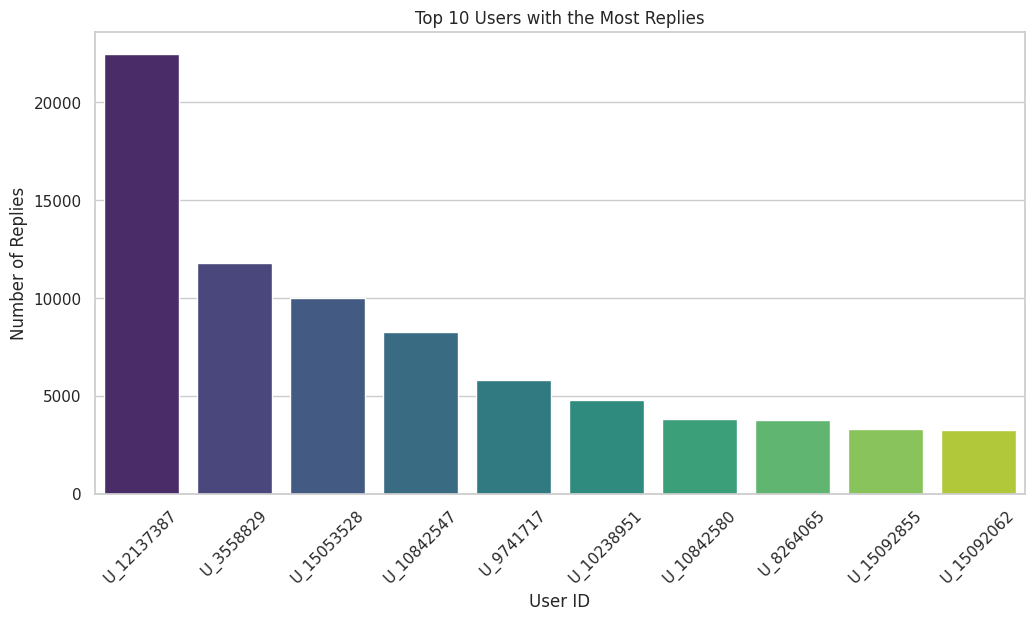

In [ ]:
# Calculate the number of replies for each user
user_reply_count = reply_df['user_id'].value_counts().reset_index()
user_reply_count.columns = ['user_id', 'reply_count']

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='user_id', y='reply_count', data=user_reply_count.head(10), palette='viridis')
plt.title('Top 10 Users with the Most Replies')
plt.xlabel('User ID')
plt.ylabel('Number of Replies')
plt.xticks(rotation=45)
plt.show()

Việc xác định số lượng reply của từng người giúp xác định sự tích cực của học viên. Biểu đồ cho thấy các học viên tích cực nhất trong việc thảo luận về các vấn đề trong các khóa học

#### 2.2.2 Thống kê reply theo thời gian

<ipython-input-99-f64acf772d50>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=reply_df, x='year', palette='viridis')


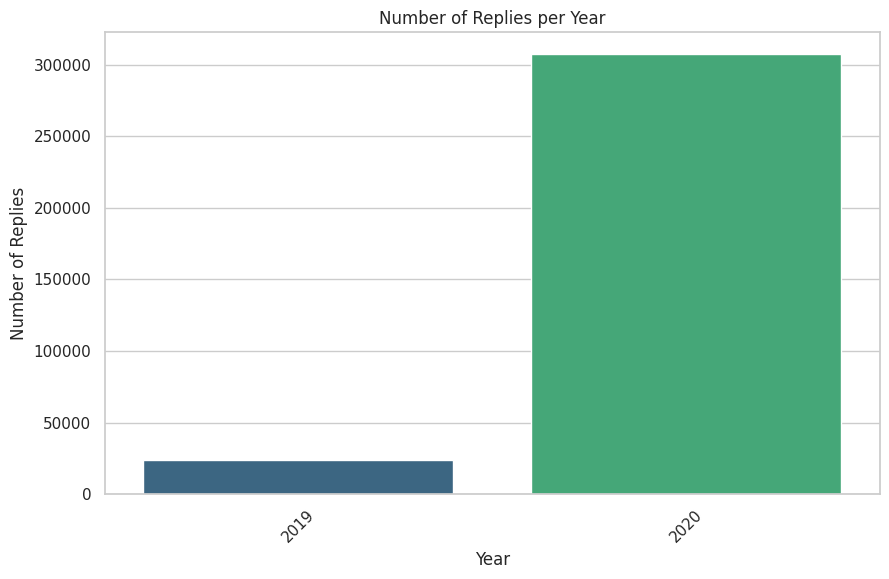

In [ ]:
# Convert the 'create_time' to datetime
reply_df['create_time'] = pd.to_datetime(reply_df['create_time'])

# Extract the year
reply_df['year'] = reply_df['create_time'].dt.year

# Now you can visualize the data
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set(style="whitegrid")

# Plot the number of replies per year
plt.figure(figsize=(10, 6))
sns.countplot(data=reply_df, x='year', palette='viridis')
plt.title('Number of Replies per Year')
plt.xlabel('Year')
plt.ylabel('Number of Replies')
plt.xticks(rotation=45)
plt.show()

Biểu đồ thể hiện xu hướng hoạt động của học viên theo từng năm

## 3. Làm sạch dữ liệu

In [ ]:
reply_df.describe()

,create_time,year
count,331011,331011.000000
mean,2020-05-15 11:05:28.672276480,2019.927839
min,2019-08-05 12:55:54,2019.000000
25%,2020-03-15 23:04:26.500000,2020.000000
50%,2020-05-14 19:46:28,2020.000000
75%,2020-06-29 01:20:21,2020.000000
max,2020-11-15 03:56:04,2020.000000
std,NaN,0.258754


In [ ]:
# Check for missing values
missing_values = reply_df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 id             0
user_id        0
text           0
create_time    0
year           0
dtype: int64


In [ ]:
# Check for duplicate rows
duplicates = reply_df.duplicated().sum()
print("Number of Duplicate Rows:", duplicates)

Number of Duplicate Rows: 0


### 3.1 Xử lý dữ liệu trùng lặp

In [ ]:
reply_df_duplicated = reply_df.duplicated(subset=["id"])

# Print the result
print(reply_df_duplicated)

0         False
1         False
2         False
3         False
4         False
          ...  
331006    False
331007    False
331008    False
331009    False
331010    False
Length: 331011, dtype: bool


In [ ]:
reply_df_duplicated.sum()

0

Nhận xét:
* File reply_df không có giá trị trùng lặp vì khi kiểm tra trùng lặp ở cột "id" thì kết quả là 0. Ta không xét các cột khác vì 1 người dùng có thể reply nhiều lần và text của người dùng khi reply thì có thể giống nhau nên ta chỉ cần đảm bảo rằng không có trường hợp nào mà hai bản ghi trong dữ liệu hoàn toàn giống nhau về tất cả các cột
